In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

data.head()

,age,height,weight,last_weight,analgesia,fertility,mode,cs_reason,e_cs,thyroid,...,norm_procedure,procedure_oxytocin,procedure_kristeller,procedure_memm,procedure_O2,procedure_minimetro,procedure_transfusion,procedure_baloon,procedure_pgf2,procedure_manualremoval
5943,34.0,153.0,75.0,84.8,0,0,経腟分娩,せず,0,0,...,div アトニン,1,0,0,0,0,0,0,0,NaN
5944,41.0,152.0,60.0,73.4,0,ART,帝王切開,双胎,0,0,...,div プロスタdiv アトニン パルタンdiv,1,0,1,0,0,0,0,1,NaN
5945,41.0,152.0,60.0,73.4,0,ART,帝王切開,双胎,0,0,...,div プロスタdiv アトニン パルタンdiv,1,0,1,0,0,0,0,1,NaN
5946,37.0,162.0,47.0,62.3,1,0,帝王切開,分娩遷延･停止,0,0,...,なし,0,0,0,0,0,0,0,0,NaN
5947,30.0,158.0,49.0,59.9,0,0,経腟分娩,せず,0,0,...,div アトニン,1,0,0,0,0,0,0,0,NaN


In [29]:
data['bmi'] = 10000*(data['weight'])/(data['height']*data['height'])
data['c/s'] = 1*(data['mode_section'])

In [30]:
data['cs_reason'].unique()

array(['せず', '双胎', '分娩遷延･停止', '卵巣嚢腫ope後 ﾐｵｰﾑ合併', '胎児機能不全', '回旋異常､胎児機能不全',
       '既往帝切', '骨盤位', '既往筋腫核出', '狭骨盤', 'CPD', 'CPD､分娩停止', '既往帝切､骨盤位',
       'CPD､反屈位', 'PIH', 'PIH･胎児機能不全', 'ｺﾝｼﾞﾛｰﾏ', '分娩遷延･停止､軟産道強靭',
       '既往帝切 足位', '骨盤位､前期破水､陣痛発来', '胎児機能不全､分娩停止', '胎児機能不全,分娩停止',
       '胎児機能不全､CPD､', '分娩遷延･停止､回旋異常', '高齢初産､軟産道強靭', '既往帝切 骨盤位',
       '胎児機能不全､CPD', '骨盤位､子宮筋腫合併', '分娩停止', 'HDP', '骨盤位  陣痛発来', '既往帝切､HDP',
       '骨盤位､FGR', 'CPD､高齢', '既往帝切･骨盤位', '回旋異常', '高血圧合併妊娠､肥満､高齢初産',
       '胎児機能不全 CPD', '胎児機能不全､回旋異常', 'CPD､胎児機能不全', '胎児機能不全,HDP､､',
       '既往帝切､双胎', '妊娠高血圧症候群', '軟産道強靭', 'CPD･分娩停止', '分娩遷延･停止､妊娠高血圧症候群',
       '前置･低位胎盤', '胎児機能不全､回旋異常､HDP', 'CPD GDM', '既往帝切,､骨盤位',
       '既往帝切､HDP､BEL', '児頭骨盤不均衡', '既往帝切､胎児機能不全', 'CPD､', 'CPD ､回旋異常',
       '回旋異常･分娩停止', '子宮奇形', '胎位異常(顔位)', '臍帯辺縁付着､高齢初産', '軟産道強靭･NRFS',
       'PIH･CPD', '分娩停止･CPD', '胎盤早期剥離', 'CPD･GDM合併', 'CPD･胎児機能不全', '希望',
       'HDP･胎児機能不全', 'HDP･CPD', '骨盤位,HDP', 'CPD､高齢､多発筋腫', '既往帝切,BEL',
       '分娩遷延･停止 HDP', '胎児機能不全､児頭骨盤不均衡'

In [3]:
print('症例数は')
print(len(data))
print('うち帝王切開=Trueの内訳は')
print(data['mode_section'].value_counts())

症例数は
5849
うち帝王切開=Trueの内訳は
mode_section
False    4014
True     1835
Name: count, dtype: int64


In [4]:
indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

In [5]:
data = data[~data['cs_reason'].isin(indications)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\2629966868.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\2629966868.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time


In [6]:
data.columns

Index(['age', 'height', 'weight', 'last_weight', 'analgesia', 'fertility',
       'mode', 'cs_reason', 'e_cs', 'thyroid', 'pmh', 'genital_cut',
       'genital_tear', 'weeks', 'days', 'labor_mode', 'labor_date',
       'labor_time', 'cervic_date', 'cervic_time', 'delivery_date',
       'delivery_time', 'procedure', 'smoke', 'G', 'P', 'apgar1', 'apgar5',
       'ph', 'medication', 'baby_girth', 'baby_weight', 'fertility_AIH',
       'fertility_ART', 'mode_vaginal', 'mode_suction', 'mode_section',
       'pmh_gast', 'pmh_ortho', 'pmh_ent', 'pmh_brain', 'pmh_blood',
       'pmh_endo', 'pmh_opt', 'pmh_psych', 'pmh_resp', 'pmh_uro', 'pmh_infect',
       'pmh_obgyn', 'pmh_allergy', 'pmh_cor', 'pmh_dent', 'weeks_days',
       'norm_procedure', 'procedure_oxytocin', 'procedure_kristeller',
       'procedure_memm', 'procedure_O2', 'procedure_minimetro',
       'procedure_transfusion', 'procedure_baloon', 'procedure_pgf2',
       'procedure_manualremoval', 'labor', 'delivery', 'duration', 'イベント'

In [31]:
from tableone import TableOne

# 変数リスト（調べたい変数の名前）
columns = ['age', 'height', 'weight', 'last_weight', 'bmi',
           'analgesia', 'weeks', 'labor_mode', 'G', 'P', 'fertility_AIH', 'fertility_ART', 
           'smoke', 'thyroid', 'pmh_gast', 'pmh_ortho', 'pmh_ent', 'pmh_brain', 'pmh_blood', 'pmh_endo', 'pmh_opt', 
           'pmh_psych', 'pmh_resp', 'pmh_uro', 'pmh_infect', 'pmh_obgyn', 'pmh_allergy', 'pmh_cor', 'pmh_dent', 
          ]

# カテゴリー変数リスト（カテゴリー変数の名前）
categorical = ['labor_mode', 'G', 'P',
              ]

# グループ化のための変数（比較したいグループがあれば）
groupby = 'analgesia'

# 非正規分布変数リスト（非正規分布の連続変数の名前）
nonnormal = [
            ]

# Table 1 の作成
table_one = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True, overall = False, htest_name=True)

# Table 1 の表示
table_one

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <function mean at 0x000001DC030144A0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <function median at 0x000001DC0315B740> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_cont = pd.pivot_table(cont_data,
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To kee

Grouped by analgesia                                                                                
                                         Missing              0             1 P-Value                                       Test
n                                                          4415          1434                                                   
age, mean (SD)                                 0     33.6 (4.7)    33.6 (4.2)   0.703                          Two Sample T-test
height, mean (SD)                              0  162.5 (239.2)   159.2 (6.5)   0.356                          Two Sample T-test
weight, mean (SD)                              0    52.8 (10.5)  55.9 (137.7)   0.383                          Two Sample T-test
last_weight, mean (SD)                         0    64.6 (99.3)  66.7 (147.6)   0.614                          Two Sample T-test
bmi, mean (SD)                                 0     20.9 (4.3)   23.7 (84.5)   0.202                          Two Sample T-test
weeks, mean (SD)                               0     38.9 (1.5)    39.3 (1.1)  <0.001                          Two Sample T-test
labor_mode, n (%)        0                     0    3741 (84.7)    621 (43.3)  <0.001                                Chi-squared
                         1                            237 (5.4)     106 (7.4)                                                   
                         2                            437 (9.9)    707 (49.3)                                                   
G, n (%)                 1                     0    1884 (42.7)    746 (52.0)  <0.001  Chi-squared (warning: expected count < 5)
                         10                             1 (0.0)                                                                 
                         2                          1492 (33.8)    443 (30.9)                                                   
                         3                           682 (15.4)    167 (11.6)                                                   
                         4                            219 (5.0)      51 (3.6)                                                   
                         5                             90 (2.0)      16 (1.1)                                                   
                         6                             27 (0.6)       6 (0.4)                                                   
                         7                             17 (0.4)       2 (0.1)                                                   
                         8                              2 (0.0)       1 (0.1)                                                   
                         9                              1 (0.0)                                                                 
                         0                                            2 (0.1)                                                   
P, n (%)                 0                     0    2413 (54.7)    937 (65.3)  <0.001  Chi-squared (warning: expected count < 5)
                         1                          1610 (36.5)    408 (28.5)                                                   
                         2                            330 (7.5)      78 (5.4)                                                   
                         3                             54 (1.2)       9 (0.6)                                                   
                         4                              8 (0.2)       1 (0.1)                                                   
                         8                                            1 (0.1)                                                   
fertility_AIH, mean (SD)                       0      0.0 (0.2)     0.1 (0.2)   0.010                          Two Sample T-test
fertility_ART, mean (SD)                       0      0.2 (0.4)     0.2 (0.4)   0.373                          Two Sample T-test
smoke, mean (SD)             

# ↓単純に無痛ありなしだけで分けたもの

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:450: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:450: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


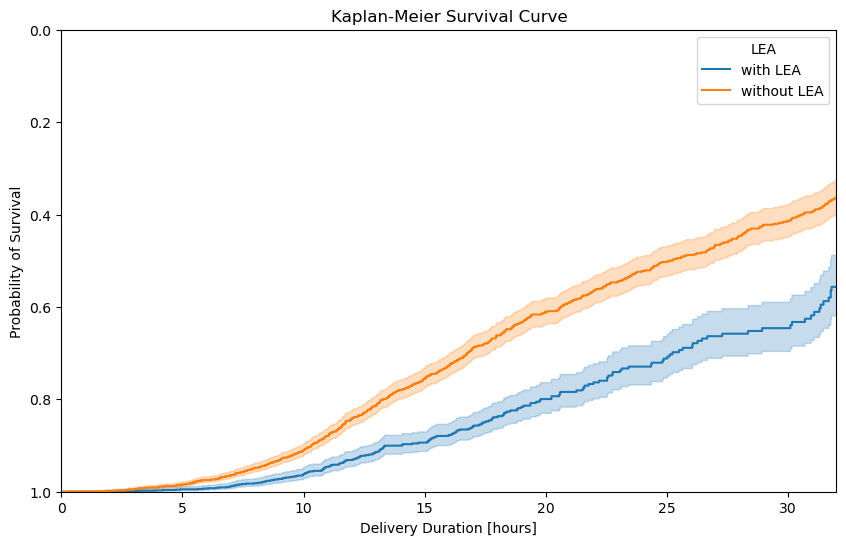

p-value: 2.701504485348685e-22


C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1217: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


<lifelines.CoxPHFitter: fitted with 5008 total observations, 4010 right-censored observations>
             duration col = 'duration'
                event col = 'イベント'
      baseline estimation = breslow
   number of observations = 5008
number of events observed = 998
   partial log-likelihood = -6829.16
         time fit was run = 2024-05-01 05:36:22 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
group     -0.75      0.47      0.08           -0.90           -0.59                0.41                0.55

           cmp to     z      p  -log2(p)
covariate                               
group        0.00 -9.49 <0.005     68.54
---
Concordance = 0.58
Partial AIC = 13660.32
log-likelihood ratio test = 102.99 on 1 df
-log2(p) of ll-ratio test = 77.97

Hazard Ratio (with LEA vs without LEA): 0.47375065370542196
95% CI for Hazard Ratio: [0.40601057298631343, 0.5527927025040318]


In [8]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Kaplan-Meier survival curve
group_with_pain_relief = data[data['analgesia'] == 1]
group_without_pain_relief = data[data['analgesia'] == 0]

kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['イベント'], label="with LEA")
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['イベント'], label="without LEA")

plt.figure(figsize=(10, 6))
kmf_with_pain_relief.plot(ci_show=True)
kmf_without_pain_relief.plot(ci_show=True)
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Probability of Survival')
plt.xlim(0, 32)
plt.ylim(1, 0)  # Correct the y-axis limits
plt.legend(title="LEA")
plt.show()

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['イベント'], event_observed_B=group_without_pain_relief['イベント'])
print("p-value:", results.p_value)

# Cox Proportional Hazards Model to calculate the Hazard Ratio
# Create a new DataFrame for the Cox model
cox_data = data.copy()
cox_data['group'] = cox_data['analgesia']

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(cox_data[['duration', 'イベント', 'group']], 'duration', event_col='イベント')

# Display the summary of the Cox model which includes the hazard ratios and confidence intervals
cph.print_summary()  # This will print out the coefficients, hazard ratios, p-values, and confidence intervals

# Assuming 'analgesia' was the original column and you have created dummy variables:
# hazard_ratios = cph.hazard_ratios_
# If 'analgesia' was converted directly to a binary variable in the 'group' column:
hazard_ratios = cph.hazard_ratios_

# Extract the hazard ratio and confidence intervals
# Replace 'analgesia' with the correct prefix if dummy variables were used
hr_with_ci = cph.summary.loc['group', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]
print(f"Hazard Ratio (with LEA vs without LEA): {hr_with_ci['exp(coef)']}")
print(f"95% CI for Hazard Ratio: [{hr_with_ci['exp(coef) lower 95%']}, {hr_with_ci['exp(coef) upper 95%']}]")


In [9]:
print('帝王切開の絶対的（超積極的）適応をのぞいた症例数は')
print(len(data))
print('うち帝王切開=Trueの内訳は')
print(data['mode_section'].value_counts())
print('LEAあり群の症例数')
print(len(group_with_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_with_pain_relief['mode_section'].value_counts())
print('LEAなし群の症例数')
print(len(group_without_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_without_pain_relief['mode_section'].value_counts()) 

帝王切開の絶対的（超積極的）適応をのぞいた症例数は
5008
うち帝王切開=Trueの内訳は
mode_section
False    4010
True      998
Name: count, dtype: int64
LEAあり群の症例数
1433
うち帝王切開=Trueの内訳は
mode_section
False    1230
True      203
Name: count, dtype: int64
LEAなし群の症例数
3575
うち帝王切開=Trueの内訳は
mode_section
False    2780
True      795
Name: count, dtype: int64


C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\1067896953.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\Users

p-value: 2.701504485348685e-22


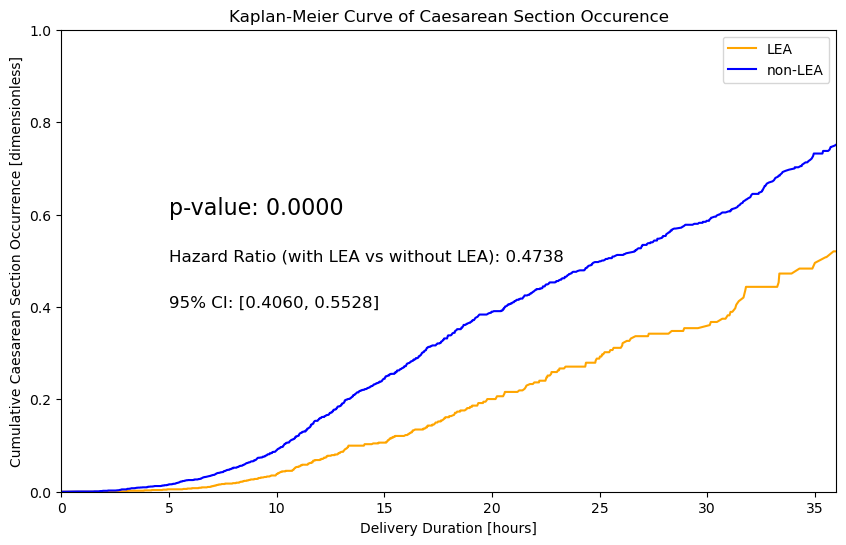

In [43]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

# データの分割
group_with_pain_relief = data[data['analgesia'] == 1]
group_without_pain_relief = data[data['analgesia'] == 0]

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# イベント発生を指定（帝王切開が「有」ならイベント発生）
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['イベント'], label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['イベント'], label='without LEA')

# 累積発生を計算
cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

# プロット
plt.figure(figsize=(10, 6))
plt.plot(cumulative_event_with_pain_relief, label='LEA', color='orange')
plt.plot(cumulative_event_without_pain_relief, label='non-LEA', color='blue')

plt.title('Kaplan-Meier Curve of Caesarean Section Occurence')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='')

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['イベント'], event_observed_B=group_without_pain_relief['イベント'])

# p値の表示
plt.text(5, 0.6, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)

print("p-value:", results.p_value)

# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data[['duration', 'イベント', 'analgesia']], 'duration', event_col='イベント')

# ハザード比と信頼区間を取得する
hr_with_ci = cph.summary.loc['analgesia', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (with LEA vs without LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\3019100921.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\Users

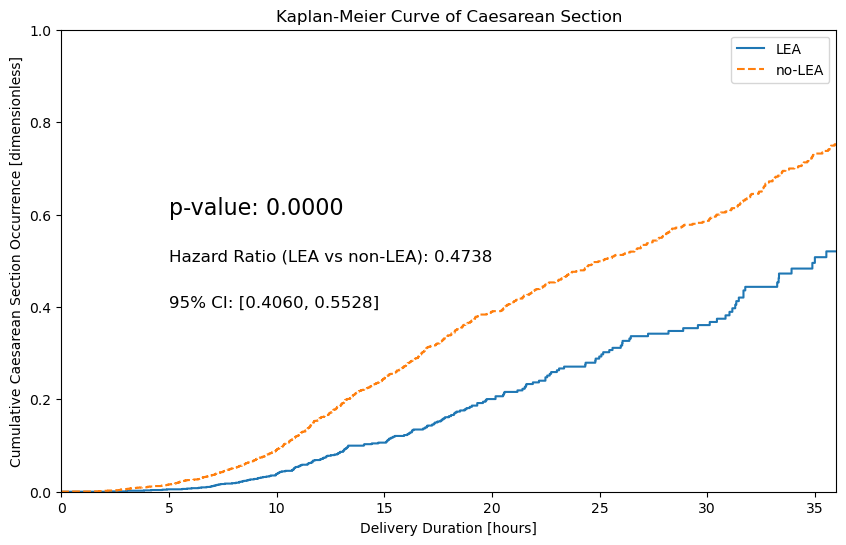

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

# データの分割
group_with_pain_relief = data[data['analgesia'] == 1]
group_without_pain_relief = data[data['analgesia'] == 0]

# Kaplan-Meier fitter instances
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# Fit the data
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['イベント'], label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['イベント'], label='without LEA')

# Plot
plt.figure(figsize=(10, 6))
# For cumulative incidence plot, subtract survival function from 1
plt.step(kmf_with_pain_relief.survival_function_.index, 1 - kmf_with_pain_relief.survival_function_['with LEA'], label='LEA', linestyle='-')  # Solid line for with LEA
plt.step(kmf_without_pain_relief.survival_function_.index, 1 - kmf_without_pain_relief.survival_function_['without LEA'], label='no-LEA', linestyle='--')  # Dashed line for without LEA

# Set plot details
plt.title('Kaplan-Meier Curve of Caesarean Section')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='')

# Log-rank test and display p-value
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['イベント'], event_observed_B=group_without_pain_relief['イベント'])
plt.text(5, 0.6, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)

# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data[['duration', 'イベント', 'analgesia']], 'duration', event_col='イベント')

# ハザード比と信頼区間を取得する
hr_with_ci = cph.summary.loc['analgesia', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (LEA vs non-LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

# ↑白黒原稿用

In [13]:
print('帝王切開の絶対的（超積極的）適応をのぞいた症例数は')
print(len(data))
print('うち帝王切開=Trueの内訳は')
print(data['mode_section'].value_counts())
print('LEAあり群の症例数')
print(len(group_with_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_with_pain_relief['mode_section'].value_counts())
print('LEAなし群の症例数')
print(len(group_without_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_without_pain_relief['mode_section'].value_counts()) 

帝王切開の絶対的（超積極的）適応をのぞいた症例数は
5008
うち帝王切開=Trueの内訳は
mode_section
False    4010
True      998
Name: count, dtype: int64
LEAあり群の症例数
1433
うち帝王切開=Trueの内訳は
mode_section
False    1230
True      203
Name: count, dtype: int64
LEAなし群の症例数
3575
うち帝王切開=Trueの内訳は
mode_section
False    2780
True      795
Name: count, dtype: int64


# ↑帝王切開の絶対（超積極的）適応を除いた症例だけでプロットしたもの

# LEAに進めなかった症例が無痛しなかった群に含まれているかもしれないので、これを無痛しなかった群からのぞいて解析して感度分析とする

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\2731725534.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\Users

p-value: 1.918158708633619e-24


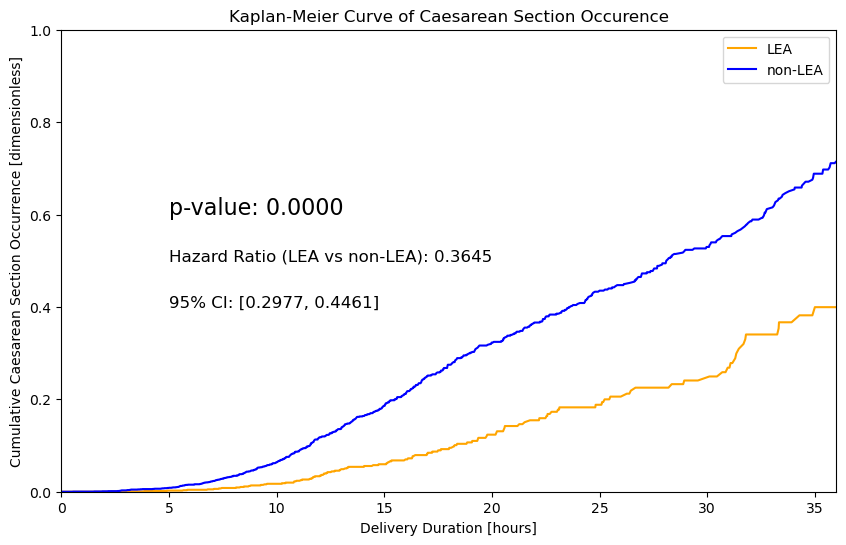

In [49]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]

incompatible_with_LEA = ['既往帝切、胎児機能不全', '胎児機能不全、回旋異常', '胎児機能不全、', '胎児機能不全、母体発熱', 
                         'CPD、胎児胎盤機能低下', '停止、胎児機能不全', 'CPD、児心音低下', 'PIH、胎児胎盤機能不全、骨盤位', 
                         '胎児機能不全、CPD', '子宮内感染の疑い', '胎児機能不全、軟産道強靭', '胎児機能不全、分娩停止', 
                         '胎児機能不全（FGR）', '胎児機能不全', '子宮内感染', '分娩停止', 'NRFS', 'CPD、分娩停止、胎児機能不全', 
                         'PIH、胎児機能不全', '胎児機能不全、児頭骨盤不均衡', '回旋異常、胎児機能不全', '胎児機能不全、CPD', 
                         'CPD、NRFS', 'PIH、NRFS ', 'CPD、回旋異常、胎児胎盤機能不全', '胎児機能不全、FGR', '胎児機能不全(FGR)', 
                         '胎児胎盤機能不全', 'PIH、NRFS ', '胎児機能不全、子宮筋腫核出後', '胎児機能不全、回旋異常、HDP', 
                         'CPD、胎児機能不全', '胎児機能不全、PIH']

data = data[~data['cs_reason'].isin(incompatible_with_LEA)]

data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

# データの分割
group_with_pain_relief = data[data['analgesia'] == 1]
group_without_pain_relief = data[data['analgesia'] == 0]

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# イベント発生を指定（帝王切開が「有」ならイベント発生）
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1, label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1, label='without LEA')

# 累積発生を計算
cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

# プロット
plt.figure(figsize=(10, 6))
plt.plot(cumulative_event_with_pain_relief, label='LEA', color='orange')
plt.plot(cumulative_event_without_pain_relief, label='non-LEA', color='blue')

plt.title('Kaplan-Meier Curve of Caesarean Section Occurence')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='')

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['mode_section'] == 1, event_observed_B=group_without_pain_relief['mode_section'] == 1)

# p値の表示
plt.text(5, 0.6, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)
print("p-value:", results.p_value)

# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data[['duration', 'イベント', 'analgesia']], 'duration', event_col='イベント')

# ハザード比と信頼区間を取得する
hr_with_ci = cph.summary.loc['analgesia', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (LEA vs non-LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

In [16]:
print('帝王切開の絶対的（超積極的）適応をのぞいて、NRFSをのぞいた症例数は')
print(len(data))
print('うち帝王切開=Trueの内訳は')
print(data['mode_section'].value_counts())
print('NRFSを含まないLEAあり群の症例数')
print(len(group_with_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_with_pain_relief['mode_section'].value_counts())
print('NRFSを含まないLEAあり群の症例数')
print(len(group_without_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_without_pain_relief['mode_section'].value_counts()) 

帝王切開の絶対的（超積極的）適応をのぞいて、NRFSをのぞいた症例数は
4662
うち帝王切開=Trueの内訳は
mode_section
False    4010
True      652
Name: count, dtype: int64
NRFSを含まないLEAあり群の症例数
1344
うち帝王切開=Trueの内訳は
mode_section
False    1230
True      114
Name: count, dtype: int64
NRFSを含まないLEAあり群の症例数
3318
うち帝王切開=Trueの内訳は
mode_section
False    2780
True      538
Name: count, dtype: int64


# ↑無痛分娩に適応がない症例がふくまれるので帝王切開の絶対的（超積極的）適応に加えて、無痛分娩に適応がない症例も除いたもの



# ほかの分娩様式（経腟、吸引）があるので、最終的な数字が大きくなっている。以下は考察に入れる

## 異なるリスクプロファイル：麻酔ありと麻酔なしのグループは異なるリスクプロファイルを持つ可能性があり、それによって帝王切開のタイミングと発生率に影響を与えることができます。

## 打ち切りデータ：Kaplan-Meierカーブは打ち切りデータ（研究が終了する前または脱落する前にイベントが観察されなかった個体）を扱います。片方のグループに打ち切りデータが多い場合、カーブの形状に影響を与える可能性があります。

## 競合リスク：C-セクションの観察を防ぐ競合リスクが存在する可能性があり、それがKaplan-Meier推定に影響を与える可能性があります。

## サンプルサイズ：一方のグループが他方よりも大幅に小さい場合、推定値は安定性が低く、変動に対して敏感になる可能性があります。

## 統計的変動：人口からの任意のサンプルには常にランダムな変動があり、直感に反する結果になる可能性があります。

それはつまりcencorのないカプランマイヤーでは全体での発生割合は２群の発生割合の間に位置することを意味しますか？

ChatGPT
いいえ、必ずしもそうとは限りません。Kaplan-Meierカーブは、イベント（この場合は帝王切開）が特定の時間点までに発生しない確率（生存確率）を推定します。そして、累積発生率は1からこの生存確率を引いたものです。

Kaplan-Meierカーブにおいて、以下の点を考慮する必要があります。

グループサイズとイベント発生のタイミング：2つのグループが異なるサイズであり、イベント（C-セクション）が発生するタイミングが異なる場合、累積発生率のカーブもそれに応じて異なります。
打ち切りデータの扱い：打ち切りデータがある場合、それらは分析に含まれますが、イベントが発生していないと見なされます。このため、打ち切りデータの多いグループは生存確率が高く見積もられる可能性があります。
たとえば、帝王切開が比較的早い段階で発生するグループと、遅い段階で発生するグループがあるとします。この場合、早い段階で帝王切開が発生するグループの累積発生率のカーブは急激に上昇し、全体の発生率よりも上になるかもしれません。逆に、もう一方のグループでは、帝王切開が発生するまでの時間が長いため、累積発生率のカーブがよりゆっくりと上昇し、全体の発生率よりも下になる可能性があります。

つまり、グループ間での発生率の違いは、グループごとのリスクプロファイルやデータの特性によって異なり、2つのグループの発生率が全体の発生率の間に位置するとは限らないのです。全体の発生率は、それぞれのグループの発生率を単純に平均したものではなく、全体のサンプルサイズと各イベントの発生タイミングに基づいて計算されます。

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]

incompatible_with_LEA = ['既往帝切、胎児機能不全', '胎児機能不全、回旋異常', '胎児機能不全、', '胎児機能不全、母体発熱', 
                         'CPD、胎児胎盤機能低下', '停止、胎児機能不全', 'CPD、児心音低下', 'PIH、胎児胎盤機能不全、骨盤位', 
                         '胎児機能不全、CPD', '子宮内感染の疑い', '胎児機能不全、軟産道強靭', '胎児機能不全、分娩停止', 
                         '胎児機能不全（FGR）', '胎児機能不全', '子宮内感染', '分娩停止', 'NRFS', 'CPD、分娩停止、胎児機能不全', 
                         'PIH、胎児機能不全', '胎児機能不全、児頭骨盤不均衡', '回旋異常、胎児機能不全', '胎児機能不全、CPD', 
                         'CPD、NRFS', 'PIH、NRFS ', 'CPD、回旋異常、胎児胎盤機能不全', '胎児機能不全、FGR', '胎児機能不全(FGR)', 
                         '胎児胎盤機能不全', 'PIH、NRFS ', '胎児機能不全、子宮筋腫核出後', '胎児機能不全、回旋異常、HDP', 
                         'CPD、胎児機能不全', '胎児機能不全、PIH']

data_ = data[data['cs_reason'].isin(incompatible_with_LEA)]
data_ = data_.dropna(subset=['labor_time'])
data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
data_['delivery_time'] = pd.to_datetime(data_['delivery_time'].astype(str).str.split().str[-1]).dt.time
data_['labor'] = pd.to_datetime(data_['labor_date'].astype(str) + ' ' + data_['labor_time'].astype(str))
data_['delivery'] = pd.to_datetime(data_['delivery_date'].astype(str) + ' ' + data_['delivery_time'].astype(str))
data_['duration'] = (data_['delivery'] - data_['labor']).dt.total_seconds() / 3600
data_['イベント'] = (data_['mode_section'] == 1).astype(int)
data_['打ち切り'] = (data_['mode_section'] == 0).astype(int)

data = data[~data['cs_reason'].isin(incompatible_with_LEA)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

group_with_LEA = data[data['analgesia'] == 1]

# データの分割
group_with_pain_relief = pd.concat([group_with_LEA, data_]).drop_duplicates()
group_without_pain_relief = data[data['analgesia'] == 0]

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# イベント発生を指定（帝王切開が「有」ならイベント発生）
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1, label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1, label='without LEA')

# 新しい列 pain_relief の追加
group_with_pain_relief['pain_relief'] = 1
group_without_pain_relief['pain_relief'] = 0

# データの結合
data_mod = pd.concat([group_with_pain_relief, group_without_pain_relief])

# 累積発生を計算
cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

# プロット
plt.figure(figsize=(10, 6))
plt.plot(cumulative_event_with_pain_relief, label='LEA', color='orange')
plt.plot(cumulative_event_without_pain_relief, label='non-LEA', color='blue')

plt.title('Kaplan-Meier Curve of Caesarean Section Occurence by LEA')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Emergency Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='')

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['mode_section'] == 1, event_observed_B=group_without_pain_relief['mode_section'] == 1)

# p値の表示
plt.text(5, 0.6, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)
print("p-value:", results.p_value)


# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data_mod[['duration', 'イベント', 'pain_relief']], duration_col='duration', event_col='イベント')

# ハザード比の取得
hr_with_ci = cph.summary.loc['pain_relief', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (with LEA vs without LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

In [18]:
print('帝王切開の絶対的（超積極的）適応をのぞいた症例数は')
print(len(data))
print('うち帝王切開=Trueの内訳は')
print(data['mode_section'].value_counts())
print('NRFSなどの症例数は')
print(len(data_))
print('うち帝王切開=Trueの内訳は')
print(data_['mode_section'].value_counts())
print('NRFSを含まないLEAあり群の症例数')
print(len(group_with_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_with_pain_relief['mode_section'].value_counts())
print('NRFSを含まないLEAあり群の症例数')
print(len(group_without_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_without_pain_relief['mode_section'].value_counts()) 

帝王切開の絶対的（超積極的）適応をのぞいた症例数は
4662
うち帝王切開=Trueの内訳は
mode_section
False    4010
True      652
Name: count, dtype: int64
NRFSなどの症例数は
346
うち帝王切開=Trueの内訳は
mode_section
True    346
Name: count, dtype: int64
NRFSを含まないLEAあり群の症例数
1690
うち帝王切開=Trueの内訳は
mode_section
False    1230
True      460
Name: count, dtype: int64
NRFSを含まないLEAあり群の症例数
3318
うち帝王切開=Trueの内訳は
mode_section
False    2780
True      538
Name: count, dtype: int64


# ↑帝王切開の絶対的（超積極的）適応を除いて、無痛分娩の適応がない症例は無痛分娩群に組み込んで感度分析

# ↑無痛分娩の適応がない症例をすべて無痛分娩軍に入れると、ハザード比の信頼区間が１をまたぐ

# NRFS移行の割合は報告で異なるが5-15%
# 無痛分娩のあるなしで変わらない
# 症例数比に応じて23%をLEAあり群に組み込む
# ランダムサンプリングを繰り返す

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\908647629.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\User

p-value: 3.3069946432097948e-24


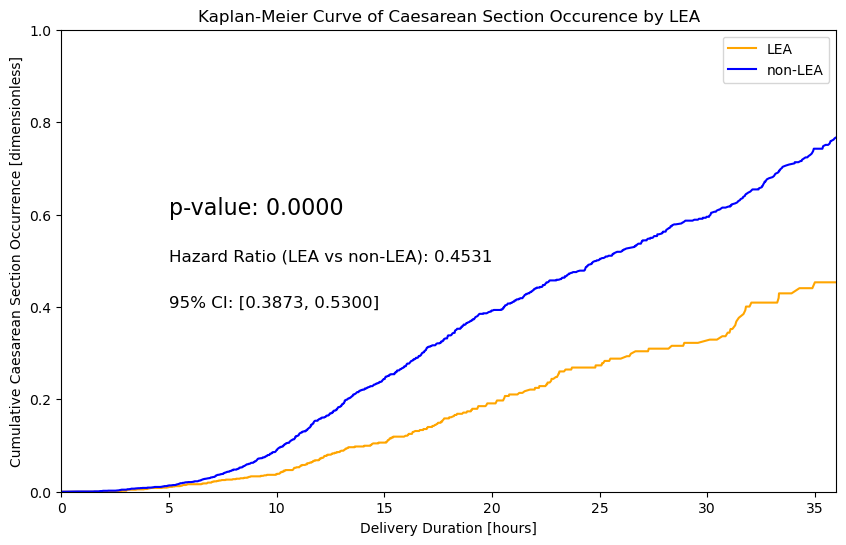

In [54]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]

incompatible_with_LEA = ['既往帝切、胎児機能不全', '胎児機能不全、回旋異常', '胎児機能不全、', '胎児機能不全、母体発熱', 
                         'CPD、胎児胎盤機能低下', '停止、胎児機能不全', 'CPD、児心音低下', 'PIH、胎児胎盤機能不全、骨盤位', 
                         '胎児機能不全、CPD', '子宮内感染の疑い', '胎児機能不全、軟産道強靭', '胎児機能不全、分娩停止', 
                         '胎児機能不全（FGR）', '胎児機能不全', '子宮内感染', '分娩停止', 'NRFS', 'CPD、分娩停止、胎児機能不全', 
                         'PIH、胎児機能不全', '胎児機能不全、児頭骨盤不均衡', '回旋異常、胎児機能不全', '胎児機能不全、CPD', 
                         'CPD、NRFS', 'PIH、NRFS ', 'CPD、回旋異常、胎児胎盤機能不全', '胎児機能不全、FGR', '胎児機能不全(FGR)', 
                         '胎児胎盤機能不全', 'PIH、NRFS ', '胎児機能不全、子宮筋腫核出後', '胎児機能不全、回旋異常、HDP', 
                         'CPD、胎児機能不全', '胎児機能不全、PIH']

data_ = data[data['cs_reason'].isin(incompatible_with_LEA)]
data_ = data_.dropna(subset=['labor_time'])
data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
data_['delivery_time'] = pd.to_datetime(data_['delivery_time'].astype(str).str.split().str[-1]).dt.time
data_['labor'] = pd.to_datetime(data_['labor_date'].astype(str) + ' ' + data_['labor_time'].astype(str))
data_['delivery'] = pd.to_datetime(data_['delivery_date'].astype(str) + ' ' + data_['delivery_time'].astype(str))
data_['duration'] = (data_['delivery'] - data_['labor']).dt.total_seconds() / 3600
data_['イベント'] = (data_['mode_section'] == 1).astype(int)
data_['打ち切り'] = (data_['mode_section'] == 0).astype(int)

data = data[~data['cs_reason'].isin(incompatible_with_LEA)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

group_with_LEA = data[data['analgesia'] == 1]
group_without_LEA = data[data['analgesia'] == 0]

# data_から23%をランダムサンプリング
sampled_data_ = data_.sample(frac=0.23, random_state=42)  # 乱数のシードを42として一貫性を持たせる
remaining_data_ = data_.drop(sampled_data_.index)

# group_with_pain_reliefを作成
group_with_pain_relief = pd.concat([group_with_LEA, sampled_data_])

# group_without_pain_reliefを作成
group_without_LEA = data[data['analgesia'] == 0]
group_without_pain_relief = pd.concat([group_without_LEA, remaining_data_])

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# イベント発生を指定（帝王切開が「有」ならイベント発生）
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1, label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1, label='without LEA')

# 新しい列 pain_relief の追加
group_with_pain_relief['pain_relief'] = 1
group_without_pain_relief['pain_relief'] = 0

# データの結合
data_mod = pd.concat([group_with_pain_relief, group_without_pain_relief])

# 累積発生を計算
cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

# プロット
plt.figure(figsize=(10, 6))
plt.plot(cumulative_event_with_pain_relief, label='LEA', color='orange')
plt.plot(cumulative_event_without_pain_relief, label='non-LEA', color='blue')

plt.title('Kaplan-Meier Curve of Caesarean Section Occurence by LEA')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='')

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['mode_section'] == 1, event_observed_B=group_without_pain_relief['mode_section'] == 1)

# p値の表示
plt.text(5, 0.6, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)
print("p-value:", results.p_value)

# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data_mod[['duration', 'イベント', 'pain_relief']], duration_col='duration', event_col='イベント')

# ハザード比の取得
hr_with_ci = cph.summary.loc['pain_relief', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (LEA vs non-LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

# ↑無痛の適応がない症例のうち無痛の実施割合23%を組み込んだ場合の結果

In [22]:
print('帝王切開の絶対的（超積極的）適応をのぞいた症例数は')
print(len(data))
print('うち帝王切開=Trueの内訳は')
print(data['mode_section'].value_counts())
print('NRFSなどの症例数は')
print(len(data_))
print('うち帝王切開=Trueの内訳は')
print(data_['mode_section'].value_counts())
print('NRFSを含まないLEAあり群の症例数')
print(len(group_with_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_with_pain_relief['mode_section'].value_counts())
print('NRFSを含むLEAあり群の症例数')
print(len(group_without_pain_relief))
print('うち帝王切開=Trueの内訳は')
print(group_without_pain_relief['mode_section'].value_counts()) 

帝王切開の絶対的（超積極的）適応をのぞいた症例数は
4662
うち帝王切開=Trueの内訳は
mode_section
False    4010
True      652
Name: count, dtype: int64
NRFSなどの症例数は
346
うち帝王切開=Trueの内訳は
mode_section
True    346
Name: count, dtype: int64
NRFSを含まないLEAあり群の症例数
1424
うち帝王切開=Trueの内訳は
mode_section
False    1230
True      194
Name: count, dtype: int64
NRFSを含むLEAあり群の症例数
3584
うち帝王切開=Trueの内訳は
mode_section
False    2780
True      804
Name: count, dtype: int64


C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\748190835.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\User

p-value: 6.71045874741623e-10


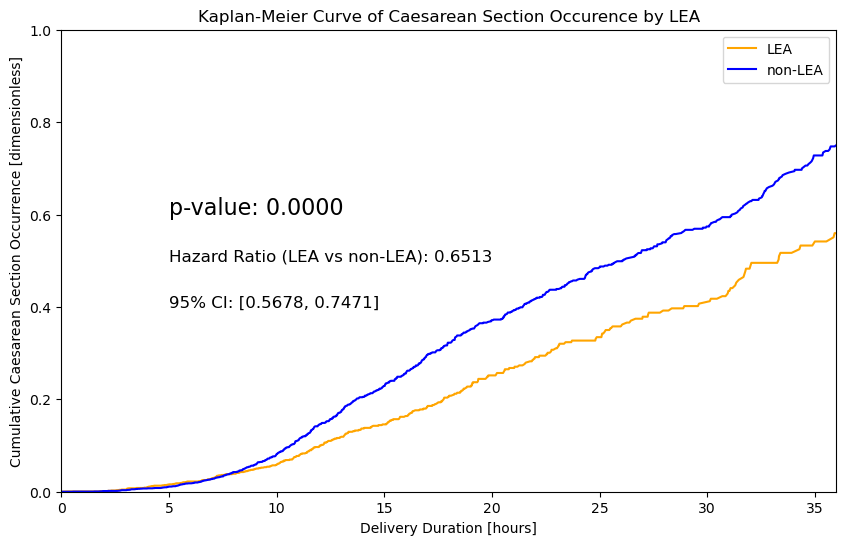

In [51]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]

incompatible_with_LEA = ['既往帝切、胎児機能不全', '胎児機能不全、回旋異常', '胎児機能不全、', '胎児機能不全、母体発熱', 
                         'CPD、胎児胎盤機能低下', '停止、胎児機能不全', 'CPD、児心音低下', 'PIH、胎児胎盤機能不全、骨盤位', 
                         '胎児機能不全、CPD', '子宮内感染の疑い', '胎児機能不全、軟産道強靭', '胎児機能不全、分娩停止', 
                         '胎児機能不全（FGR）', '胎児機能不全', '子宮内感染', '分娩停止', 'NRFS', 'CPD、分娩停止、胎児機能不全', 
                         'PIH、胎児機能不全', '胎児機能不全、児頭骨盤不均衡', '回旋異常、胎児機能不全', '胎児機能不全、CPD', 
                         'CPD、NRFS', 'PIH、NRFS ', 'CPD、回旋異常、胎児胎盤機能不全', '胎児機能不全、FGR', '胎児機能不全(FGR)', 
                         '胎児胎盤機能不全', 'PIH、NRFS ', '胎児機能不全、子宮筋腫核出後', '胎児機能不全、回旋異常、HDP', 
                         'CPD、胎児機能不全', '胎児機能不全、PIH']

data_ = data[data['cs_reason'].isin(incompatible_with_LEA)]
data_ = data_.dropna(subset=['labor_time'])
data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
data_['delivery_time'] = pd.to_datetime(data_['delivery_time'].astype(str).str.split().str[-1]).dt.time
data_['labor'] = pd.to_datetime(data_['labor_date'].astype(str) + ' ' + data_['labor_time'].astype(str))
data_['delivery'] = pd.to_datetime(data_['delivery_date'].astype(str) + ' ' + data_['delivery_time'].astype(str))
data_['duration'] = (data_['delivery'] - data_['labor']).dt.total_seconds() / 3600
data_['イベント'] = (data_['mode_section'] == 1).astype(int)
data_['打ち切り'] = (data_['mode_section'] == 0).astype(int)

data = data[~data['cs_reason'].isin(incompatible_with_LEA)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

group_with_LEA = data[data['analgesia'] == 1]
group_without_LEA = data[data['analgesia'] == 0]

# data_から23%をランダムサンプリング
sampled_data_ = data_.sample(frac=0.5, random_state=42)  # 乱数のシードを42として一貫性を持たせる
remaining_data_ = data_.drop(sampled_data_.index)

# group_with_pain_reliefを作成
group_with_pain_relief = pd.concat([group_with_LEA, sampled_data_])

# group_without_pain_reliefを作成
group_without_LEA = data[data['analgesia'] == 0]
group_without_pain_relief = pd.concat([group_without_LEA, remaining_data_])

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# イベント発生を指定（帝王切開が「有」ならイベント発生）
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1, label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1, label='without LEA')

# 新しい列 pain_relief の追加
group_with_pain_relief['pain_relief'] = 1
group_without_pain_relief['pain_relief'] = 0

# データの結合
data_mod = pd.concat([group_with_pain_relief, group_without_pain_relief])

# 累積発生を計算
cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

# プロット
plt.figure(figsize=(10, 6))
plt.plot(cumulative_event_with_pain_relief, label='LEA', color='orange')
plt.plot(cumulative_event_without_pain_relief, label='non-LEA', color='blue')

plt.title('Kaplan-Meier Curve of Caesarean Section Occurence by LEA')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='')

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['mode_section'] == 1, event_observed_B=group_without_pain_relief['mode_section'] == 1)

# p値の表示
plt.text(5, 0.6, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)
print("p-value:", results.p_value)

# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data_mod[['duration', 'イベント', 'pain_relief']], duration_col='duration', event_col='イベント')

# ハザード比の取得
hr_with_ci = cph.summary.loc['pain_relief', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (LEA vs non-LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

# ↑無痛の適応がない症例のうち無痛の実施割合50%を組み込んだ場合の結果

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\AppData\Local\Temp\ipykernel_35580\2706555309.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
C:\Use

p-value: 0.06264603050762815


C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1217: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


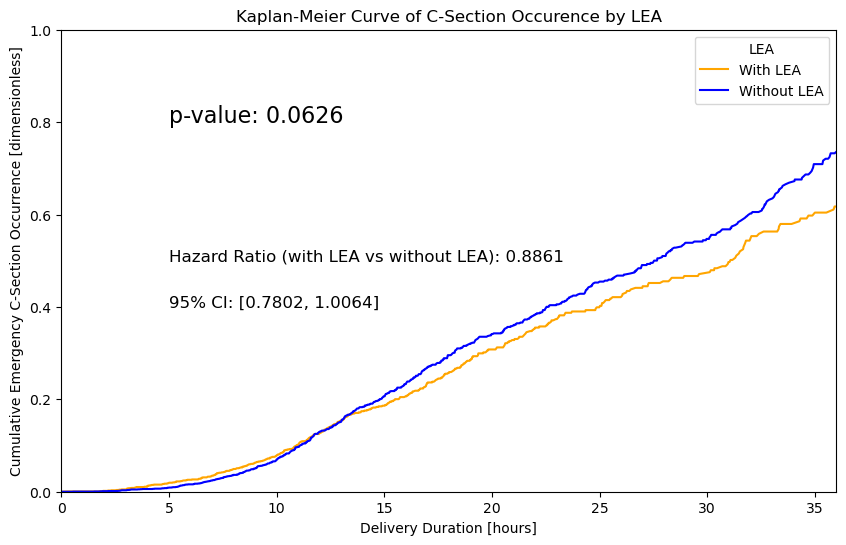

In [59]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# Update this with the correct file path
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

indications = ['既往筋腫核出、骨盤位', '既往帝切、胎児機能不全', '両股関節唇損傷手術既往', '既往帝切、前期破水', '双胎', 
               '常位胎盤早期剥離疑い', '既往子宮筋腫手術', '母体合併症（脳動脈瘤）', '子宮角部妊娠術後のため', 
               'HDP、低置胎盤、高齢', '子宮内胎児発育遅延', 'PIH、胎児胎盤機能不全、骨盤位', '低置胎盤、軟産道強靭', 
               '骨盤位、HDP', '胎児機能不全（FGR）', 'IUGR', 'FGR', '子宮筋腫合併', '胎盤早期剥離の疑い', '既往帝王切開', 
               '胎盤早期剥離', '子宮筋腫合併妊娠', '産道感染（外陰部ヘルペス）', '既往筋腫核出、既往帝王切開', '既往帝切、PIH', 
               '骨盤位、前期破水、陣痛発来', 'PIH／低位胎盤', 'ミオーム合併', '既往帝切、骨盤位', '臍帯辺縁付着、高齢初産', 
               'コンジローマ', 'ヘルペス治療後', '外陰ヘルペス', '既往子宮手術', '低位胎盤', '子宮頸部筋腫合併', 
               '既往帝切、陣痛発来', '前置', '低置胎盤', '早剥疑い', '骨盤位', '骨盤位.腹痛.出血', '胎位', 
               '前回分娩時Ⅳ度裂傷にて', 'ラパロ手術歴あり', '既往帝切、HDP ', '早期胎盤剥離疑い', '前置胎盤', 
               '前回早剥、本人希望', '既往帝切、BEL', '既往帝切、PIH', '子宮内膜症ope後', '既往筋腫核出、低置胎盤', 
               '骨盤位、子宮筋腫合併', '常位胎盤早期剥離', 'ミオメク後', 'PIH、羊水過症、FGR', '既往筋腫核出', '既往帝切、陣発', 
               '既往帝切', 'BEL', '筋腫核出術後', '骨盤位、FGR', '横位', '低地胎盤', '外陰部ヘルペス', 'コンジローマ感染', 
               '子宮筋腫術後', '既往帝切、切迫早産', '足位', '重複子宮', '希望']

data = data[~data['cs_reason'].isin(indications)]

incompatible_with_LEA = ['既往帝切、胎児機能不全', '胎児機能不全、回旋異常', '胎児機能不全、', '胎児機能不全、母体発熱', 
                         'CPD、胎児胎盤機能低下', '停止、胎児機能不全', 'CPD、児心音低下', 'PIH、胎児胎盤機能不全、骨盤位', 
                         '胎児機能不全、CPD', '子宮内感染の疑い', '胎児機能不全、軟産道強靭', '胎児機能不全、分娩停止', 
                         '胎児機能不全（FGR）', '胎児機能不全', '子宮内感染', '分娩停止', 'NRFS', 'CPD、分娩停止、胎児機能不全', 
                         'PIH、胎児機能不全', '胎児機能不全、児頭骨盤不均衡', '回旋異常、胎児機能不全', '胎児機能不全、CPD', 
                         'CPD、NRFS', 'PIH、NRFS ', 'CPD、回旋異常、胎児胎盤機能不全', '胎児機能不全、FGR', '胎児機能不全(FGR)', 
                         '胎児胎盤機能不全', 'PIH、NRFS ', '胎児機能不全、子宮筋腫核出後', '胎児機能不全、回旋異常、HDP', 
                         'CPD、胎児機能不全', '胎児機能不全、PIH']

data_ = data[data['cs_reason'].isin(incompatible_with_LEA)]
data_ = data_.dropna(subset=['labor_time'])
data_['labor_time'] = pd.to_datetime(data_['labor_time'].astype(str).str.split().str[-1]).dt.time
data_['delivery_time'] = pd.to_datetime(data_['delivery_time'].astype(str).str.split().str[-1]).dt.time
data_['labor'] = pd.to_datetime(data_['labor_date'].astype(str) + ' ' + data_['labor_time'].astype(str))
data_['delivery'] = pd.to_datetime(data_['delivery_date'].astype(str) + ' ' + data_['delivery_time'].astype(str))
data_['duration'] = (data_['delivery'] - data_['labor']).dt.total_seconds() / 3600
data_['イベント'] = (data_['mode_section'] == 1).astype(int)
data_['打ち切り'] = (data_['mode_section'] == 0).astype(int)

data = data[~data['cs_reason'].isin(incompatible_with_LEA)]
data = data.dropna(subset=['labor_time'])
data['labor_time'] = pd.to_datetime(data['labor_time'].astype(str).str.split().str[-1]).dt.time
data['delivery_time'] = pd.to_datetime(data['delivery_time'].astype(str).str.split().str[-1]).dt.time
data['labor'] = pd.to_datetime(data['labor_date'].astype(str) + ' ' + data['labor_time'].astype(str))
data['delivery'] = pd.to_datetime(data['delivery_date'].astype(str) + ' ' + data['delivery_time'].astype(str))
data['duration'] = (data['delivery'] - data['labor']).dt.total_seconds() / 3600
data['イベント'] = (data['mode_section'] == 1).astype(int)
data['打ち切り'] = (data['mode_section'] == 0).astype(int)

group_with_LEA = data[data['analgesia'] == 1]
group_without_LEA = data[data['analgesia'] == 0]

# data_から23%をランダムサンプリング
sampled_data_ = data_.sample(frac=0.8, random_state=42)  # 乱数のシードを42として一貫性を持たせる
remaining_data_ = data_.drop(sampled_data_.index)

# group_with_pain_reliefを作成
group_with_pain_relief = pd.concat([group_with_LEA, sampled_data_])

# group_without_pain_reliefを作成
group_without_LEA = data[data['analgesia'] == 0]
group_without_pain_relief = pd.concat([group_without_LEA, remaining_data_])

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

# イベント発生を指定（帝王切開が「有」ならイベント発生）
kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1, label='with LEA')
kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1, label='without LEA')

# 新しい列 pain_relief の追加
group_with_pain_relief['pain_relief'] = 1
group_without_pain_relief['pain_relief'] = 0

# データの結合
data_mod = pd.concat([group_with_pain_relief, group_without_pain_relief])

# 累積発生を計算
cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

# プロット
plt.figure(figsize=(10, 6))
plt.plot(cumulative_event_with_pain_relief, label='With LEA',color='orange')
plt.plot(cumulative_event_without_pain_relief, label='Without LEA',color='blue')

plt.title('Kaplan-Meier Curve of C-Section Occurence by LEA')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Emergency C-Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(title='LEA')

# Log-rank test
results = logrank_test(group_with_pain_relief['duration'], group_without_pain_relief['duration'],
                       event_observed_A=group_with_pain_relief['mode_section'] == 1, event_observed_B=group_without_pain_relief['mode_section'] == 1)

# p値の表示
plt.text(5, 0.8, 'p-value: {:.4f}'.format(results.p_value), fontsize=16)
print("p-value:", results.p_value)

# Cox Proportional Hazards modelのフィット
cph = CoxPHFitter()
cph.fit(data_mod[['duration', 'イベント', 'pain_relief']], duration_col='duration', event_col='イベント')

# ハザード比の取得
hr_with_ci = cph.summary.loc['pain_relief', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# プロットにハザード比と信頼区間を追加する
plt.text(5, 0.5, f"Hazard Ratio (with LEA vs without LEA): {hr_with_ci['exp(coef)']:.4f}", fontsize=12)
plt.text(5, 0.4, f"95% CI: [{hr_with_ci['exp(coef) lower 95%']:.4f}, {hr_with_ci['exp(coef) upper 95%']:.4f}]", fontsize=12)

plt.show()

# ↑無痛の適応がない症例の80%を無痛あり群に組み込むとほぼ同等になる。つまり、無痛適応をうまくしなければならぬというメッセージ

# 100回回すよー

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


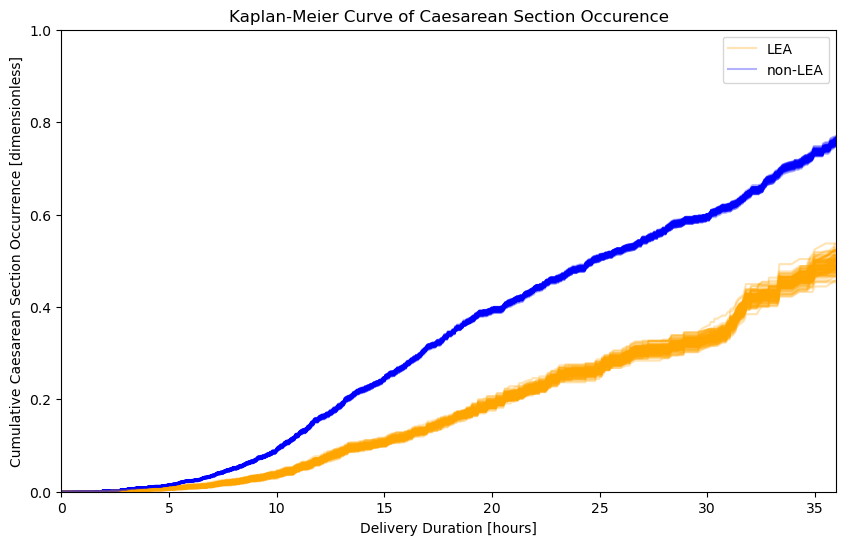

In [44]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# データのロード
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# random_stateを0から99まで変更してループ
for seed in range(100):
    # data_から15%をランダムサンプリング
    sampled_data_ = data_.sample(frac=0.23, random_state=seed)
    remaining_data_ = data_.drop(sampled_data_.index)

    # group_with_pain_reliefを作成
    group_with_pain_relief = pd.concat([group_with_LEA, sampled_data_])
    
    # group_without_pain_reliefを作成
    group_without_pain_relief = pd.concat([group_without_LEA, remaining_data_])

    # イベント発生を指定（帝王切開が「有」ならイベント発生）
    kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1)
    kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1)

    # 累積発生を計算
    cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
    cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

    # プロット (透明度を設定して重ねて描画)
    plt.plot(cumulative_event_with_pain_relief, alpha=0.3, color='orange')
    plt.plot(cumulative_event_without_pain_relief, alpha=0.3, color='blue')
    
# プロットの設定
plt.title('Kaplan-Meier Curve of Caesarean Section Occurence')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(['LEA', 'non-LEA'], title='')

plt.show()

# ↑23%ランダムサンプリング繰り返し

C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\bougt\anaconda3\envs\eda\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


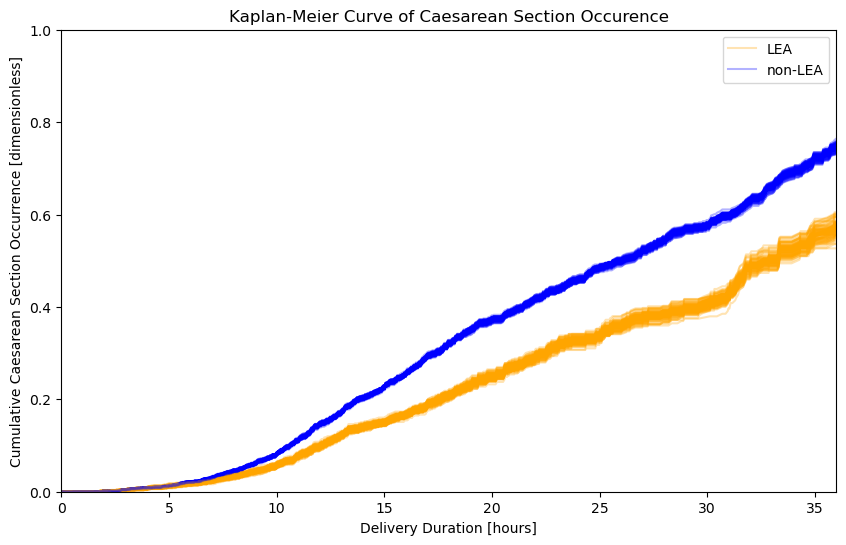

In [60]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
import matplotlib.pyplot as plt

# データのロード
data = pd.read_excel('D:/from_689/adachi_concat.xlsx')
data = data[data['labor_date']>='2018-08-01 00:00:00']

# Kaplan-Meier fitterのインスタンス化
kmf_with_pain_relief = KaplanMeierFitter()
kmf_without_pain_relief = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# random_stateを0から99まで変更してループ
for seed in range(100):
    # data_から15%をランダムサンプリング
    sampled_data_ = data_.sample(frac=0.5, random_state=seed)
    remaining_data_ = data_.drop(sampled_data_.index)

    # group_with_pain_reliefを作成
    group_with_pain_relief = pd.concat([group_with_LEA, sampled_data_])
    
    # group_without_pain_reliefを作成
    group_without_pain_relief = pd.concat([group_without_LEA, remaining_data_])

    # イベント発生を指定（帝王切開が「有」ならイベント発生）
    kmf_with_pain_relief.fit(group_with_pain_relief['duration'], event_observed=group_with_pain_relief['mode_section'] == 1)
    kmf_without_pain_relief.fit(group_without_pain_relief['duration'], event_observed=group_without_pain_relief['mode_section'] == 1)

    # 累積発生を計算
    cumulative_event_with_pain_relief = 1 - kmf_with_pain_relief.survival_function_
    cumulative_event_without_pain_relief = 1 - kmf_without_pain_relief.survival_function_

    # プロット (透明度を設定して重ねて描画)
    plt.plot(cumulative_event_with_pain_relief, alpha=0.3, color='orange')
    plt.plot(cumulative_event_without_pain_relief, alpha=0.3, color='blue')
    
# プロットの設定
plt.title('Kaplan-Meier Curve of Caesarean Section Occurence')
plt.xlabel('Delivery Duration [hours]')
plt.ylabel('Cumulative Caesarean Section Occurrence [dimensionless]')
plt.xlim(0, 36)
plt.ylim(0, 1)
plt.legend(['LEA', 'non-LEA'], title='')

plt.show()

In [ ]:
# ↑50%ランダムサンプリング繰り返す